# Load Library and Data

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import Row
import pyspark.pandas as ps
from pyspark.sql.functions import col
import pyspark

from datetime import datetime, date
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
sns.set_style('whitegrid')

# consistent sized plots 
from pylab import rcParams
rcParams['figure.figsize'] = 12,5
rcParams['axes.labelsize']= 14
rcParams['xtick.labelsize'] =12
rcParams['ytick.labelsize'] = 12 

import warnings
warnings.filterwarnings("ignore")

In [46]:
spark = SparkSession.builder.appName('1').getOrCreate()
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")
spark.conf.set('spark.sql.repl.eagerEval.maxNumRows', 5)
spark.conf.set('spark.sql.repl.eagerEval.enabled', True)

In [47]:
sdf = spark.read.csv('SouthGermanCredit.csv', header=True, inferSchema=True)
sdf_encoded = spark.read.csv('SouthGermanCredit.asc', sep=' ', header=True)

psdf = sdf.toPandas()
psdf_encoded = sdf_encoded.toPandas()
for column in psdf_encoded:
    psdf_encoded[column] = psdf_encoded[column].astype('float')
    
psdf_encoded['id'] = sdf.select('_c0').toPandas()
sdf_encoded = spark.createDataFrame(psdf_encoded) 

# EDA

In [5]:
psdf_encoded.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
status,1000.0,2.577,1.257638,1.0,1.00,2.0,4.00,4.0
duration,1000.0,20.903,12.058814,4.0,12.00,18.0,24.00,72.0
credit_history,1000.0,2.545,1.083120,0.0,2.00,2.0,4.00,4.0
purpose,1000.0,2.828,2.744439,0.0,1.00,2.0,3.00,10.0
amount,1000.0,3271.248,2822.751760,250.0,1365.50,2319.5,3972.25,18424.0
savings,1000.0,2.105,1.580023,1.0,1.00,1.0,3.00,5.0
employment_duration,1000.0,3.384,1.208306,1.0,3.00,3.0,5.00,5.0
installment_rate,1000.0,2.973,1.118715,1.0,2.00,3.0,4.00,4.0
personal_status_sex,1000.0,2.682,0.708080,1.0,2.00,3.0,3.00,4.0
other_debtors,1000.0,1.145,0.477706,1.0,1.00,1.0,1.00,3.0


<AxesSubplot:xlabel='credit_risk', ylabel='count'>

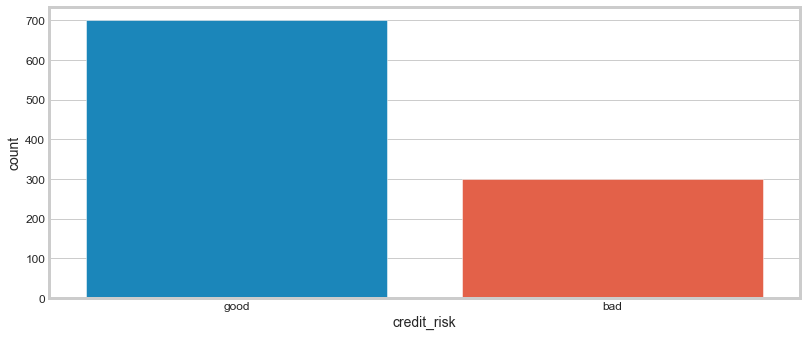

In [6]:
sns.countplot(psdf['credit_risk'])

# Preprocessing

In [48]:
cols = sdf_encoded.columns
#numerical features
numerical_cols = ['duration', 'age', 'amount']
#categorical features 
categorical_cols = [ele for ele in cols if ele not in numerical_cols]

### Train Test Split

In [49]:
#create label column
sdf_encoded = sdf_encoded.withColumn("label", sdf_encoded.credit_risk)

#Train test split
train, test = sdf_encoded.randomSplit([0.8, 0.2])

### Normalize

In [50]:
import pyspark.sql.functions as F
from math import log
#normalisasi distribusi dengan transformasi log
for col in numerical_cols:
    train = train.withColumn(col, F.log(F.col(col)))

### Vector Assembling 

In [51]:
from pyspark.ml.feature import VectorAssembler

features = [ele for ele in sdf_encoded.columns if (ele != 'credit_risk') & (ele != 'label') & (ele != 'id')]

#Train
assemble_train = VectorAssembler(inputCols=features, outputCol='features')
assembled_train = assemble_train.transform(train)
final_train = assembled_train.select('features', 'label')

#Test
assemble_test = VectorAssembler(inputCols=features, outputCol='features')
assembled_test = assemble_test.transform(test)
final_test = assembled_test.select('features', 'label')

# Classification

In [52]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator()

## Logistic Regression

In [53]:
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)

lrModel = lr.fit(assembled_train)

In [54]:
prediction_train = lrModel.transform(assembled_train)
print('Train ROC', evaluator.evaluate(prediction_train))

Train ROC 0.8051405363400438


In [56]:
prediction_test = lrModel.transform(assembled_test)
print('Test Area Under ROC', evaluator.evaluate(prediction_test))

Test Area Under ROC 0.43840121426764483


## Decision Tree

In [57]:
dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', maxDepth = 3)

dtModel = dt.fit(assembled_train)

In [58]:
prediction_train_dt = dtModel.transform(assembled_train)
print('Train ROC', evaluator.evaluate(prediction_train_dt))

Train ROC 0.7327280324912394


In [59]:
prediction_test_dt = dtModel.transform(assembled_test)
print('Test ROC', evaluator.evaluate(prediction_test_dt))

Test ROC 0.6566531748039464


## Random Forest

In [60]:
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')

rfModel = rf.fit(assembled_train)

In [61]:
prediction_train_rf = rfModel.transform(assembled_train)
print('Train ROC', evaluator.evaluate(prediction_train_rf))

Train ROC 0.8988094365350499


In [62]:
prediction_test_rf = rfModel.transform(assembled_test)
print('Test ROC', evaluator.evaluate(prediction_test_rf))

Test ROC 0.7426637996458385


## Gradient Boost

In [63]:
gb = GBTClassifier(featuresCol = 'features', labelCol = 'label', maxIter=5)

gbModel = gb.fit(assembled_train)

In [64]:
prediction_train_gb = gbModel.transform(assembled_train)
print('Train ROC', evaluator.evaluate(prediction_train_gb))

Train ROC 0.9320557746726684


In [65]:
prediction_test_gb = gbModel.transform(assembled_test)
print('Test ROC', evaluator.evaluate(prediction_test_gb))

Test ROC 0.6139640779155073


# Hyper Parameter Tuning 

In [244]:
[int(x) for x in np.linspace(start = 5, stop = 25, num = 3)]

[5, 15, 25]

In [66]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
paramGrid = (ParamGridBuilder()
             .addGrid(rf.numTrees, [int(x) for x in np.linspace(start = 10, stop = 50, num = 3)])
             .addGrid(rf.maxDepth, [int(x) for x in np.linspace(start = 5, stop = 25, num = 3)])
             .build())
cv = CrossValidator(estimator=rf, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)

cvModel = cv.fit(assembled_train)
predictions = cvModel.transform(assembled_test)
evaluator.evaluate(predictions)

0.7479129774854542

#  Evaluation Analysis of Data Test Prediction

In [163]:
#load clustering result data
df_clustering = pd.read_csv('clustering result.csv')
label_dict = {0: 'bad',
             1: 'good'}

df_predictions_encoded = predictions.toPandas()
#get decoded data
df_predictions = df_predictions_encoded[['id','prediction']].merge(psdf, how='left', left_on='id', right_on='_c0').drop('_c0', axis=1)
#merge with clustering result
df_predictions = df_predictions.merge(df_clustering[['_c0','cluster']], how='left', left_on='id', right_on='_c0').drop('_c0', axis=1)
#decoded prediction
df_predictions.replace({"prediction": label_dict}, inplace=True)

## Feature Importance

In [178]:
feature_importance = pd.DataFrame(data=features, columns=['feature'])
feature_importance['importance'] = ''
for i in range(len(features)):
    feature_importance['importance'][feature_importance['feature'].eq(features[i])] = rfModel.featureImportances[i]

top3_feauture = feature_importance.sort_values(by='importance', ascending=False)[:4]
top3_feauture

,feature,importance
0,status,0.240313
1,duration,0.138082
4,amount,0.108788
2,credit_history,0.071211


#### Status

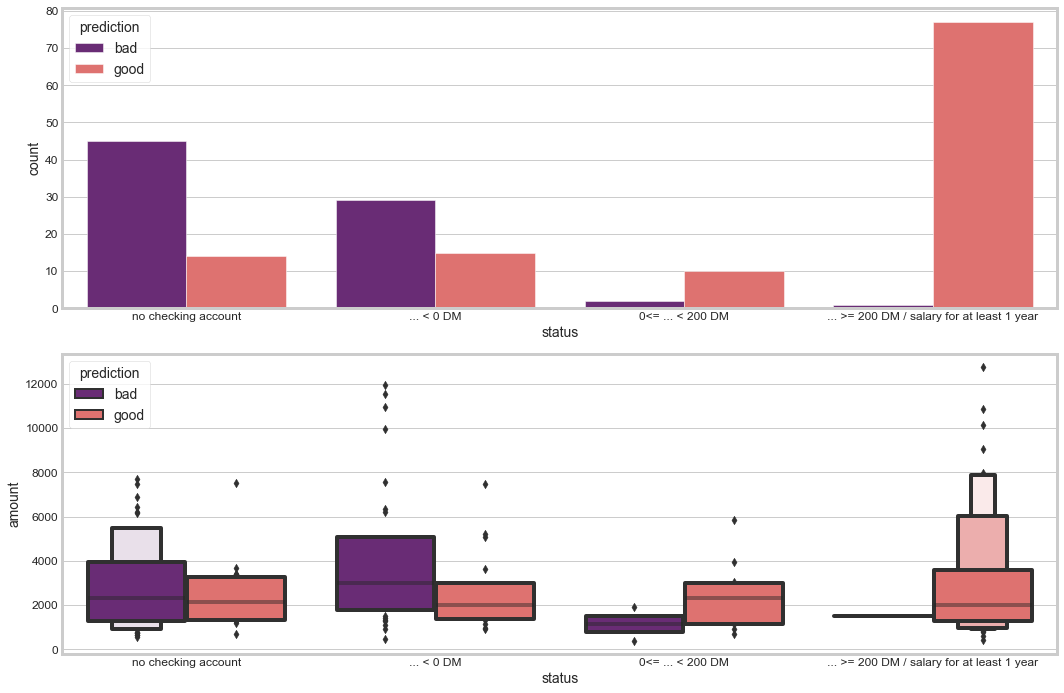

In [165]:
fig, ax =plt.subplots(2,1,figsize=(15,10))
plt.tight_layout(2)

sns.countplot(df_predictions['status'], hue=df_predictions['prediction'], ax=ax[0], palette='magma');
sns.boxenplot(df_predictions['status'], df_predictions['amount'], hue=df_predictions['prediction'], ax=ax[1], palette='magma');

#### Amout x duration

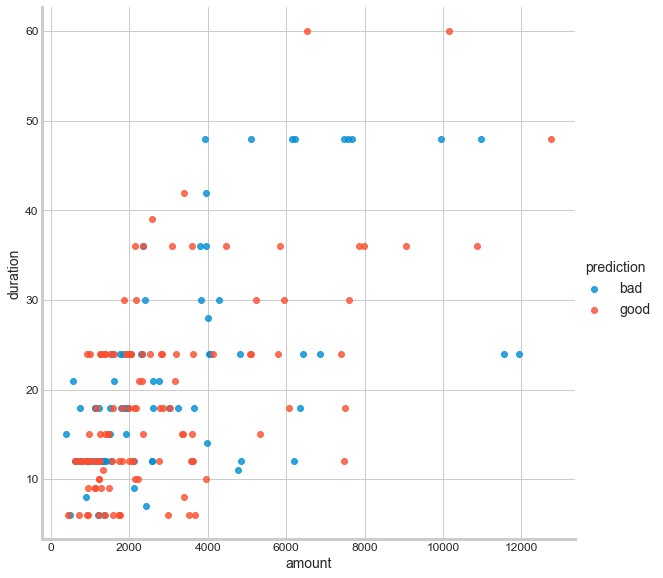

In [208]:
sns.lmplot(x='amount', y='duration', hue='prediction', data=df_predictions, fit_reg=False, height=8)

#### Credit History

<AxesSubplot:xlabel='credit_history', ylabel='count'>

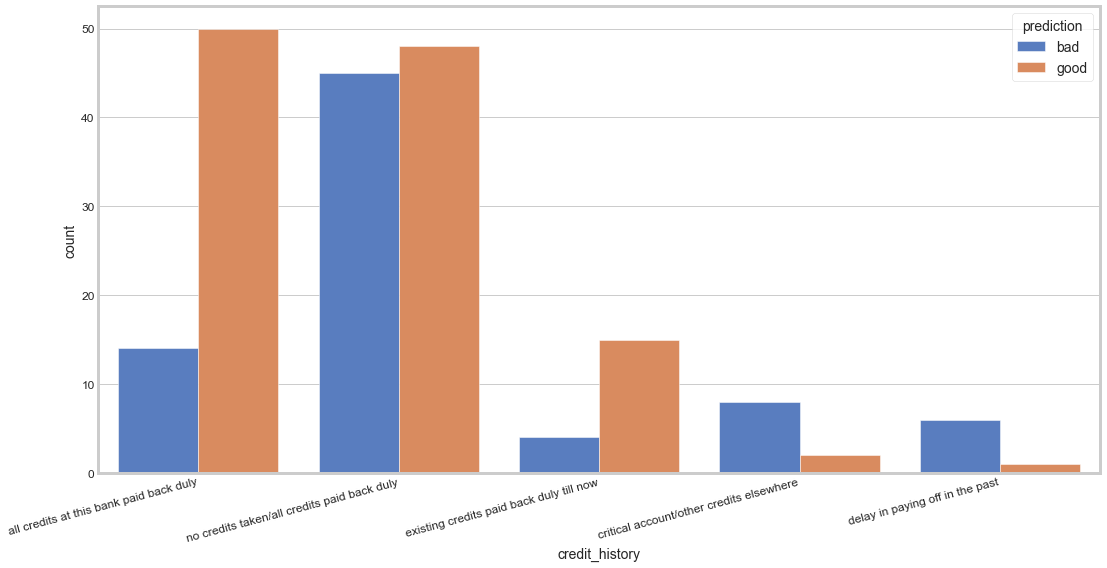

In [205]:
fig, ax = plt.subplots(1,1, figsize =(16,8))
ax.set_xticklabels(df_predictions['credit_history'].unique(), rotation = 15, ha="right")
sns.countplot(df_predictions['credit_history'], hue=df_predictions['prediction'], palette='muted')

## Correlation Matrix

<AxesSubplot:>

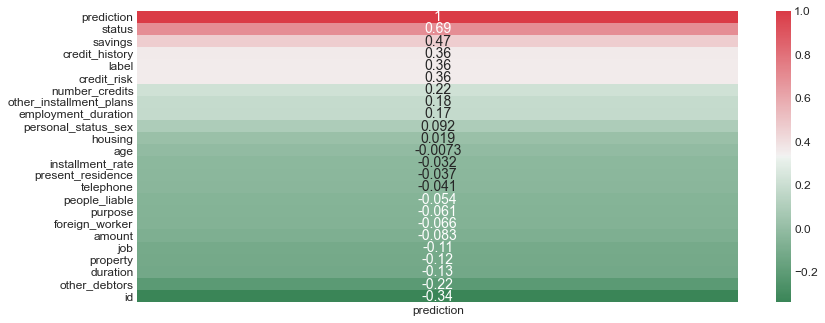

In [239]:
# calculate the correlation matrix
corr = df_predictions_encoded.corr()[['prediction']].sort_values(by='prediction', ascending=False)

# Colors
cmap = sns.diverging_palette(500, 10, as_cmap=True)

# plot the heatmap
sns.heatmap(corr, 
            xticklabels=corr.columns,
            yticklabels=corr.index,
            cmap=cmap,
            annot=True)

# Result Interpretation

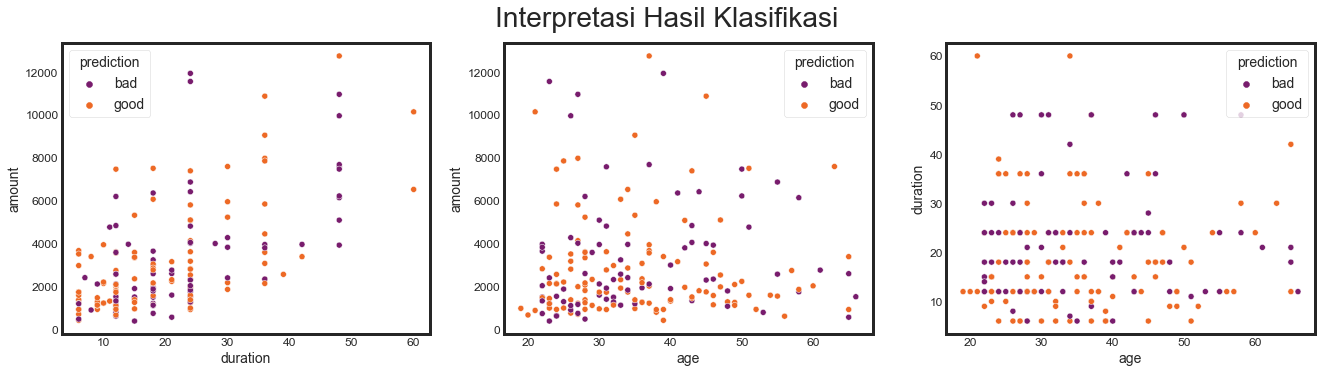

In [257]:
#Scatter plot hasil classification
fig, ax  = plt.subplots(1,3,figsize=(20,5))
fig.suptitle('Interpretasi Hasil Klasifikasi', fontsize=28)
sns.scatterplot(df_predictions['duration'], df_predictions['amount'], hue=df_predictions['prediction'], ax=ax[0], palette='inferno');
sns.scatterplot(df_predictions['age'], df_predictions['amount'], hue=df_predictions['prediction'], ax=ax[1], palette='inferno');
sns.scatterplot(df_predictions['age'], df_predictions['duration'], hue=df_predictions['prediction'], ax=ax[2], palette='inferno');

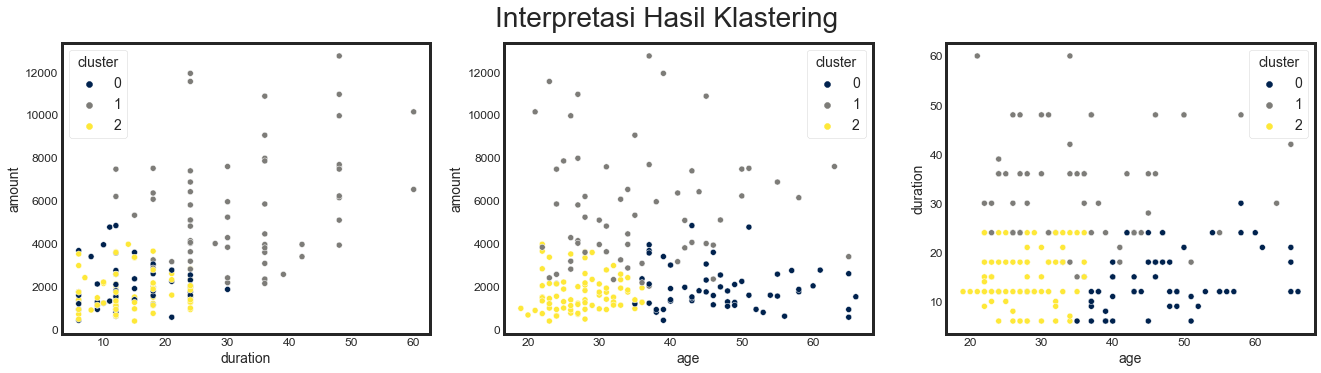

In [258]:
#Scatter plot hasil classification
fig, ax  = plt.subplots(1,3,figsize=(20,5))
fig.suptitle('Interpretasi Hasil Klastering', fontsize=28)
sns.scatterplot(df_predictions['duration'], df_predictions['amount'], hue=df_predictions['cluster'], ax=ax[0], palette='cividis');
sns.scatterplot(df_predictions['age'], df_predictions['amount'], hue=df_predictions['cluster'], ax=ax[1], palette='cividis');
sns.scatterplot(df_predictions['age'], df_predictions['duration'], hue=df_predictions['cluster'], ax=ax[2], palette='cividis');